In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import glob, os
from numpy import pi, sqrt, cos, sin, radians, arcsin
%matplotlib widget

def extract_from_txt(file_path, labels, delimiter='\n'):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_dict = {label: [] for label in labels}
    last_delimiter_index = 0
    messages = []
    for i in range(len(lines)):
        if(lines[i].startswith(delimiter)):
            messages.append(lines[last_delimiter_index:i])
            last_delimiter_index = i
    for message in messages:
        message_dict = {label: [] for label in labels}
        for label in labels:
            for line in message:
                    if(line.startswith(label)):
                        message_dict[label].append(float(line.split(':')[1]))
        full = True
        for key in message_dict:
            if(len(message_dict[key]) == 0):
                full=False
                break
        if(full):
            for label in labels:
                data_dict[label].append(message_dict[label][0])

    # for series in data_dict:
    #     print(series, len(data_dict[series]))

    df_raw = pd.DataFrame(data_dict)
    return df_raw

def remove_even_lines(input_file_path, output_file_path):
    with open(input_file_path, 'r') as file:
        lines = file.readlines()
    
    with open(output_file_path, 'w') as file:
        for i, line in enumerate(lines):
            if i % 2 == 0:
                file.write(line)

def butterworth_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

In [74]:
# encoder_file = max(glob.glob(f"{root_dir}/{trial}/data/*encoder.txt"), key=os.path.getctime)
# force_file = max(glob.glob(f"{root_dir}/{trial}/data/*force.txt"), key=os.path.getctime)

df_encoder = pd.read_csv('spring2_encoder.csv')
df_encoder2 = pd.read_csv('spring2_encoder2.csv')

force_file = 'spring2_force.txt'
force_data_path = force_file[:-4] + '_filt.txt'
remove_even_lines(force_file, force_data_path)
df_force = extract_from_txt(
    force_data_path, 
    [
        'elapsed',
        'looptime',
        'N23', 
        'N67'
    ],
    '\n'
)
force_file2 = 'spring2_force2.txt'
force_data_path2 = force_file2[:-4] + '_filt.txt'
remove_even_lines(force_file2, force_data_path2)
df_force2 = extract_from_txt(
    force_data_path2, 
    [
        'elapsed',
        'looptime',
        'N23', 
        'N67'
    ],
    '\n'
)

df_force.loc[:,'time'] = np.cumsum(df_force['looptime']) / 1e6
df_force2.loc[:,'time'] = np.cumsum(df_force2['looptime']) / 1e6
df_encoder['time'] = df_encoder['micros']/1e6
df_encoder2['time'] = df_encoder2['micros']/1e6

df_encoder['encoder'] = (df_encoder['encoder'] + 2**13) % 2**14
# df_encoder2['encoder'] = (df_encoder2['encoder'] + 2**13) % 2**14

display(df_force, df_encoder)

,elapsed,looptime,N23,N67,time
0,5672.0,665.0,-0.096847,0.338718,0.000665
1,5673.0,659.0,-0.253305,0.372160,0.001324
2,5674.0,662.0,-0.165662,0.337305,0.001986
3,5674.0,661.0,-0.047724,0.290946,0.002647
4,5675.0,661.0,0.055826,0.219206,0.003308
...,...,...,...,...,...
101785,73048.0,662.0,13.671576,0.220326,67.370399
101786,73048.0,662.0,13.688057,0.239261,67.371061
101787,73049.0,662.0,13.598877,0.259106,67.371723
101788,73050.0,662.0,13.534639,0.276916,67.372385


,micros,encoder,time
0,2904.0,8195.0,0.002904
1,6168.0,8192.0,0.006168
2,9456.0,8192.0,0.009456
3,12740.0,8194.0,0.012740
4,16052.0,8195.0,0.016052
...,...,...,...
14705,51899444.0,8226.0,51.899444
14706,51902924.0,8223.0,51.902924
14707,51906404.0,8227.0,51.906404
14708,51909888.0,8226.0,51.909888


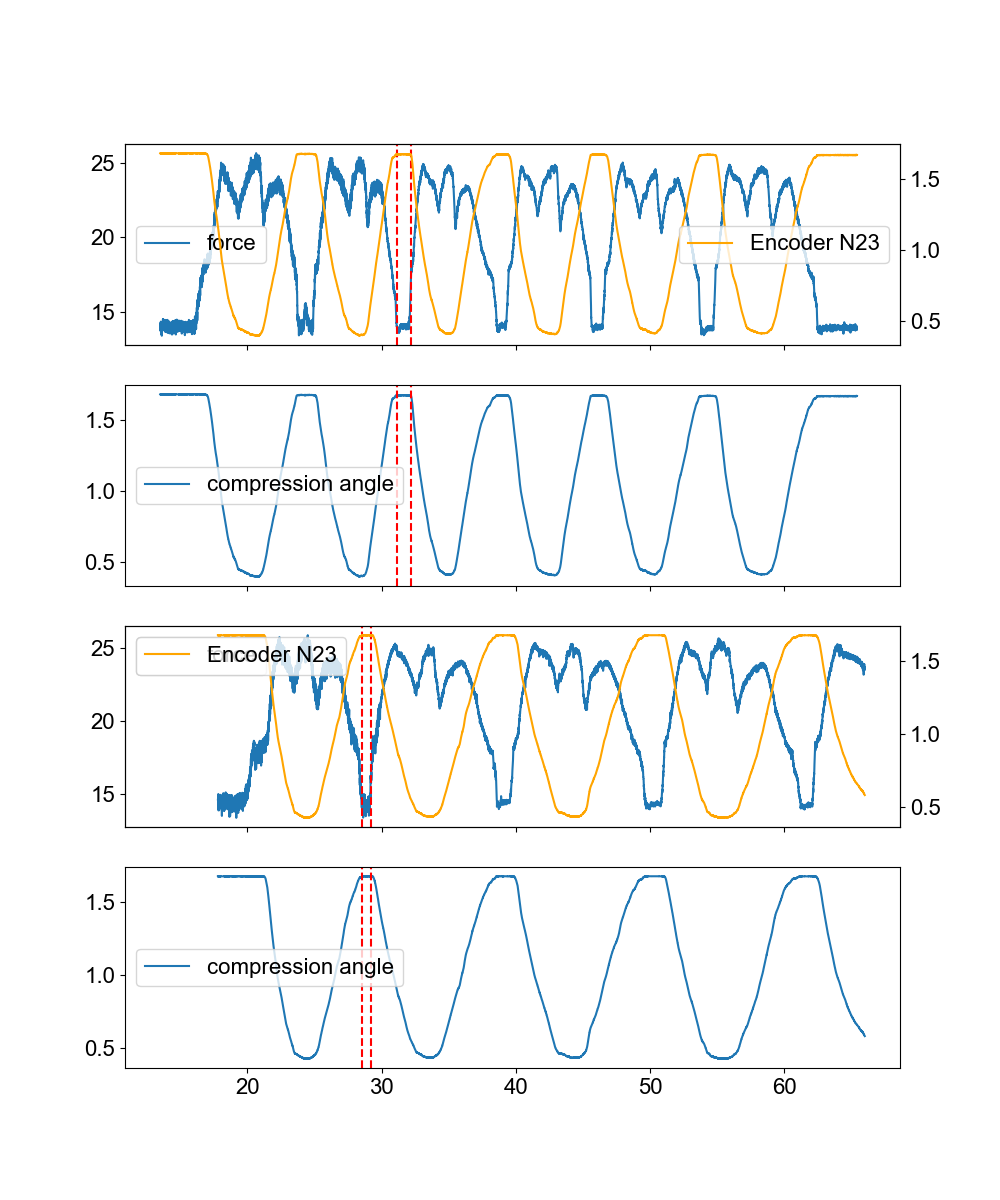

In [80]:
angle_init = radians(96.12)

offset = 13.5
offset2 = 17.8

df_encoder['angle'] = angle_init - radians(df_encoder['encoder']/(2**14) * 360 - 180)
df_encoder['time_adj'] = df_encoder['time'] + offset
df_encoder2['angle'] = angle_init - radians(df_encoder2['encoder']/(2**14) * 360 - 180)
df_encoder2['time_adj'] = df_encoder['time'] + offset2

df_encoder2['angle'] = df_encoder2['angle']%pi


df_encoder = df_encoder[df_encoder['time_adj'] < 66]
df_encoder2 = df_encoder2[df_encoder2['angle'] > 0]
df_encoder2 = df_encoder2[df_encoder2['time_adj'] < 66]

from scipy.interpolate import interp1d
interpolator = interp1d(df_force['time'], df_force['N23'], fill_value="extrapolate")
df_encoder['N23_interp'] = interpolator(df_encoder['time_adj'])
interpolator2 = interp1d(df_force2['time'], df_force2['N23'], fill_value="extrapolate")
df_encoder2['N23_interp'] = interpolator2(df_encoder2['time_adj'])

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(10,12))
# axs[0].plot(df_force['time'], df_force['N23'])
axs[0].plot(df_encoder['time_adj'], df_encoder['N23_interp'], label='force')
axs[1].plot(df_encoder['time_adj'], df_encoder['angle'], label='compression angle')

axs0_twin = axs[0].twinx()
axs0_twin.plot(df_encoder['time_adj'], df_encoder['angle'], color='orange', label='Encoder N23')
axs0_twin.legend()

# axs[1].legend()

for offset_line in [32.18, 31.14]:
    axs[0].axvline(offset_line, linestyle='dashed', color='red')
    axs[1].axvline(offset_line, linestyle='dashed', color='red')
# axs[1].axvline(46.8)

# axs[2].plot(df_force2['time'], df_force2['N23'])
axs[2].plot(df_encoder2['time_adj'], df_encoder2['N23_interp'], label='force')
axs[3].plot(df_encoder2['time_adj'], df_encoder2['angle'], label='compression angle')
# axs[3].legend()

axs2_twin = axs[2].twinx()
axs2_twin.plot(df_encoder2['time_adj'], df_encoder2['angle'], color='orange', label='Encoder N23')
axs2_twin.legend()

for offset_line in [28.53, 29.19]:
    axs[2].axvline(offset_line, linestyle='dashed', color='red')
    axs[3].axvline(offset_line, linestyle='dashed', color='red')

for ax in axs:
    ax.legend()




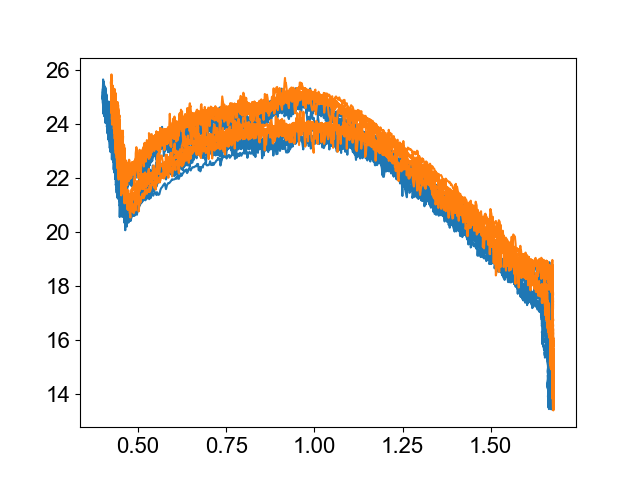

In [81]:
plt.figure()
plt.plot(df_encoder['angle'], df_encoder['N23_interp'])
plt.plot(df_encoder2['angle'], df_encoder2['N23_interp'])

/var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/ipykernel_28450/537105917.py:32: RuntimeWarning: invalid value encountered in divide
  Ts = Fs *L2 * L2*sin(thetas)/Ls


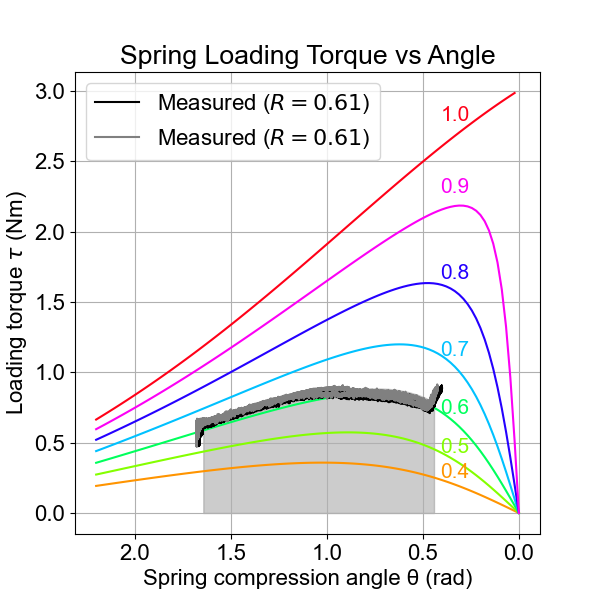

In [82]:
plt.figure(figsize=(6,6))
# plt.figure()

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16


L1 = 0.057896
theta_start = radians(94.1)
theta_end = radians(94.1 - 68.8)
thetas = np.linspace(2.2, 0, 100)
L0 = 0.085
n_springs = 6
k = 43*n_springs
F0 = 5*n_springs

L2_real = 0.035384
R_real = L2_real/L1
# print(R_real)



# L2 = 35.384
# for R in np.linspace(0.3, 0.9, 6):
for R in [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    L2 = R*L1
    L1_rescale = L1

    Ls = sqrt(L1_rescale**2 + L2**2 - 2*L1_rescale*L2*cos(thetas))
    Fs = k*(L0 - Ls) + F0
    # phis = arcsin()
    Ts = Fs *L2 * L2*sin(thetas)/Ls
    T_norms = Ts/max(Ts)


    color = plt.cm.hsv(R*1.5-0.5)  # Use a red-blue colormap to vary color based on R
    # plt.plot(thetas, Ts, label=f"{R:.1f}", color=color)
    plt.plot(thetas, Ts, color=color)

    mid_index = int(len(thetas)*0.84)
    plt.text(thetas[mid_index], Ts[mid_index]+(R-0.25)*0.1, f"{R:.1f}", fontsize=15, color=color, ha='center', va='bottom')
    # print(R)


thetas = np.linspace(theta_start, theta_end, 50)
L2 = R_real * L1
Ls = sqrt(L1**2 + L2**2 - 2*L1*L2*cos(thetas))
Fs = k*(L0 - Ls) + F0
phis = arcsin(L2*sin(thetas)/Ls)
Ts = Fs*L2*sin(phis)
T_norms = Ts/max(Ts)
# plt.plot(thetas, Ts, label=f"0.61 (Chosen)", color='black')


x_fill = thetas[(thetas <= theta_start) & (thetas >= theta_end)]
y_fill = Ts[(thetas <= theta_start) & (thetas >= theta_end)]
plt.fill_between(x_fill, y_fill, color='gray', alpha=0.4)


plt.plot(df_encoder['angle'], df_encoder['N23_interp'] * L2_real, label='Measured ($R=0.61$)', color='black')
plt.plot(df_encoder2['angle'], df_encoder2['N23_interp'] * L2_real, label='Measured ($R=0.61$)', color='gray')



# plt.ylim(ymin=0, ymax=50)
plt.xlabel('Spring compression angle θ (rad)')
plt.ylabel('Loading torque $τ$ (Nm)')
plt.title('Spring Loading Torque vs Angle')
plt.grid(True)
plt.gca().invert_xaxis()
# plt.legend( title="$R=L_2/L_1$")
plt.legend()

plt.savefig('spring_torque_plot.pdf', format='pdf')

0.9306939372272

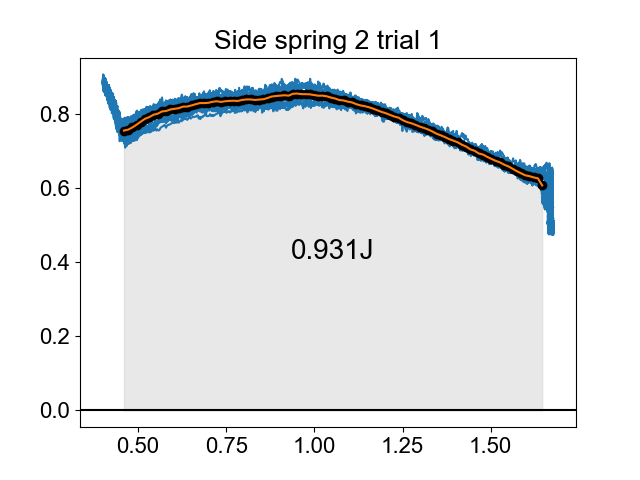

In [98]:
plt.figure()

torque = df_encoder['N23_interp'] * L2_real

plt.plot(df_encoder['angle'], torque)
plt.axhline(color='black')

min_ang = 0.46
max_ang = 1.646
ang_range = np.linspace(min_ang, max_ang, 100)
tolerance = (ang_range[1] - ang_range[0])/2  # Define the tolerance level

torque_avgs = []
for x in ang_range:
    within_tol = np.abs(df_encoder['angle'] - x) <= tolerance
    torque_avg = torque.loc[within_tol].mean()
    torque_avgs.append(torque_avg)

    # plt.scatter(df_encoder.loc[within_tol, 'angle'], torque.loc[within_tol], alpha=0.1)
    plt.plot(x, torque_avg, 'ko')

torque_avgs = np.array(torque_avgs)

plt.fill_between(ang_range, torque_avgs, color='lightgray', alpha=0.5)
plt.plot(ang_range, torque_avgs)

energy = np.trapz(torque_avgs, ang_range)

plt.text((min_ang + max_ang) / 2, max(torque_avgs)/2, f'{energy:.3f}J',  horizontalalignment='center', verticalalignment='center', fontsize=20, color='black')

plt.title("Side spring 2 trial 1")
plt.savefig('spring_energy_s21.png')
energy

0.9445769512633093

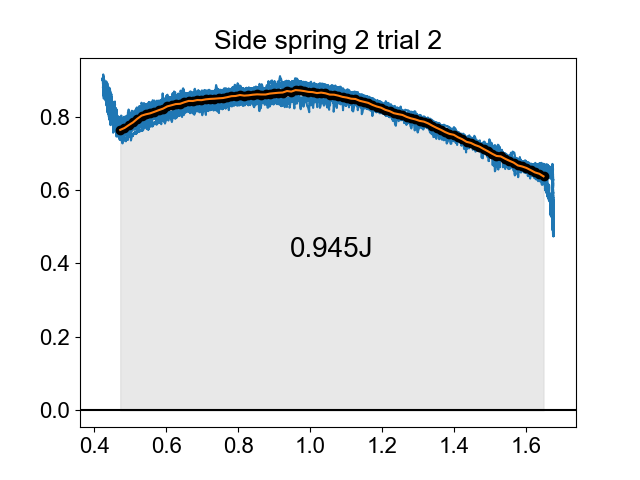

In [101]:
plt.figure()

torque = df_encoder2['N23_interp'] * L2_real

plt.plot(df_encoder2['angle'], torque)
plt.axhline(color='black')

min_ang = 0.472
max_ang = 1.65
ang_range = np.linspace(min_ang, max_ang, 100)
tolerance = (ang_range[1] - ang_range[0])/2  # Define the tolerance level

torque_avgs = []
for x in ang_range:
    within_tol = np.abs(df_encoder2['angle'] - x) <= tolerance
    torque_avg = torque.loc[within_tol].mean()
    torque_avgs.append(torque_avg)

    # plt.scatter(df_encoder2.loc[within_tol, 'angle'], torque.loc[within_tol], alpha=0.1)
    plt.plot(x, torque_avg, 'ko')

torque_avgs = np.array(torque_avgs)

plt.fill_between(ang_range, torque_avgs, color='lightgray', alpha=0.5)
plt.plot(ang_range, torque_avgs)

energy = np.trapz(torque_avgs, ang_range)

plt.text((min_ang + max_ang) / 2, max(torque_avgs)/2, f'{energy:.3f}J',  horizontalalignment='center', verticalalignment='center', fontsize=20, color='black')
plt.title("Side spring 2 trial 2")
plt.savefig('spring_energy_s22.png')


energy